# Introduction

New York City's demographics show that it is a large and ethnically diverse metropolis. It is the largest city in the United States with a long history of international immigration. New York City was home to nearly 8.5 million people in 2014, accounting for over 40% of the population of New York State and a slightly lower percentage of the New York metropolitan area, home to approximately 23.6 million. Over the last decade the city has been growing faster than the region. The New York region continues to be by far the leading metropolitan gateway for legal immigrants admitted into the United States.

Throughout its history, New York City has been a major point of entry for immigrants; the term "melting pot" was coined to describe densely populated immigrant neighborhoods on the Lower East Side. As many as 800 languages are spoken in New York, making it the most linguistically diverse city in the world. English remains the most widely spoken language, although there are areas in the outer boroughs in which up to 25% of people speak English as an alternate language, and/or have limited or no English language fluency. English is least spoken in neighborhoods such as Flushing, Sunset Park, and Corona.

With it's diverse culture , comes diverse food items. There are many resturants in New york City, each beloning to different categories like Chinese , Indian , French, Russian etc.

So as part of this project , we will list and visualize all major parts of New York City that has great russian crusine resturants.


# Data

For this project we need the following data :
* New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
    - Data source : https://cocl.us/new_york_dataset
* Russian resturants in each neighborhood of new york city.
    - Data source : Fousquare API
* GeoSpace data
    - Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

# Analysis

In [139]:
!pip install folium
!pip install os
!pip install geocoder
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

print('Libraries imported.')

  ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os
Libraries imported.


In [140]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [152]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = '4YU5PR2ETLLQMX5FQ2KZUFEHYDOJV1RRECSCVAFLS1GKFQOT' # your Foursquare ID
    CLIENT_SECRET = 'YOG1B3VYW0VXOQDZSDC3OCTW41ZN0OXNFNHPPPH0WBP0EA10' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [142]:
def get_venue_details(venue_id):
        
    CLIENT_ID = '4YU5PR2ETLLQMX5FQ2KZUFEHYDOJV1RRECSCVAFLS1GKFQOT' # your Foursquare ID
    CLIENT_SECRET = 'YOG1B3VYW0VXOQDZSDC3OCTW41ZN0OXNFNHPPPH0WBP0EA10' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [143]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [144]:
# get new york data
new_york_data=get_new_york_data()

In [145]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [146]:
new_york_data.shape

(306, 4)

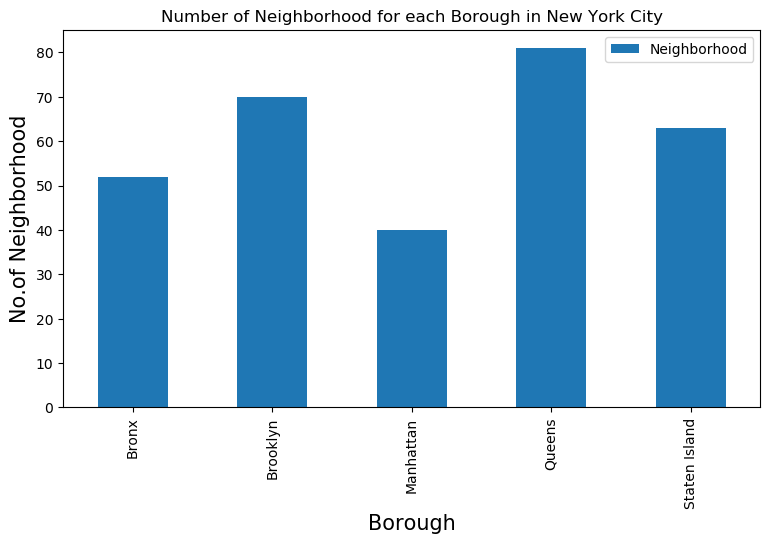

In [147]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [151]:
# prepare neighborhood list that contains russian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
russian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    russian_resturants=venues[venues['Category']=='Russian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Russian Resturants in '+Neighborhood+', '+Borough+':'+str(len(russian_resturants)))
    for resturant_detail in russian_resturants.values.tolist():
        id, name , category=resturant_detail
        russian_rest_ny = russian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

KeyError: 0

In [134]:
russian_rest_ny

,Borough,Neighborhood,ID,Name


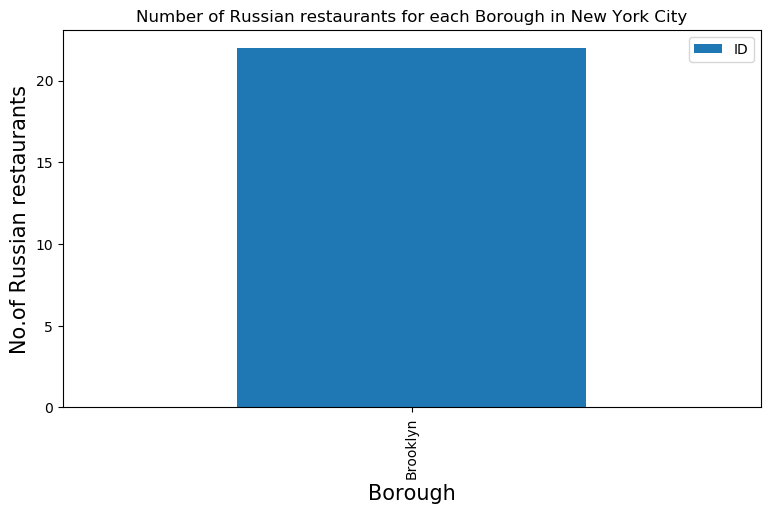

In [50]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Russian restaurants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Russian restaurants', fontsize=15)
#giving a bar plot
russian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

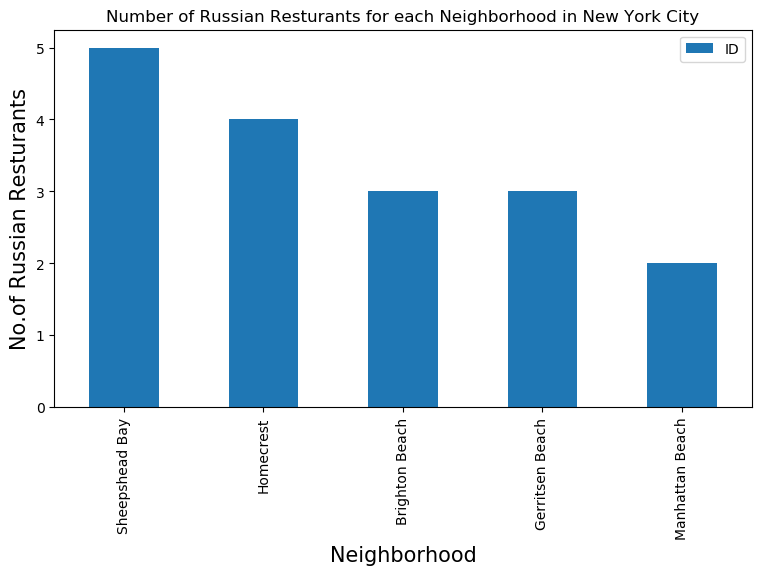

In [53]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Russian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Russian Resturants', fontsize=15)
#giving a bar plot
russian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [57]:
russian_rest_ny[russian_rest_ny['Neighborhood']=='Sheepshead Bay']

,Borough,Neighborhood,ID,Name
4,Brooklyn,Sheepshead Bay,5a08f7e2d48ec1369706f57d,Bellarussian Xata
5,Brooklyn,Sheepshead Bay,55d6885e498e41b9e7b8b5e8,Cafe Dushanbe
6,Brooklyn,Sheepshead Bay,5324ee02498e9a825bb4f689,La Vue Restaurant
7,Brooklyn,Sheepshead Bay,4b2ecbf5f964a520cee624e3,Passage
8,Brooklyn,Sheepshead Bay,4b53cec1f964a520f9ab27e3,Vanka Vstanka


In [60]:
# prepare neighborhood list that contains russian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
russian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in russian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(russian_rest_ny),')','processed')
    russian_rest_stats_ny = russian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID       Name  Likes  Rating  Tips
0  4a2937fcf964a52069951fe3  Stolovaya     41     7.9    27
( 1 / 22 ) processed
                         ID        Name  Likes  Rating  Tips
0  4ac69109f964a52017b520e3  Skovorodka     91     7.8    48
( 2 / 22 ) processed
                         ID                Name  Likes  Rating  Tips
0  4245f780f964a52070201fe3  Tatiana Restaurant    157     7.1    67
( 3 / 22 ) processed
                         ID        Name  Likes  Rating  Tips
0  4c1ea63763750f474c19ba67  Volna Café     32     6.3    20
( 4 / 22 ) processed
                         ID               Name  Likes  Rating  Tips
0  5a08f7e2d48ec1369706f57d  Bellarussian Xata     22     8.9     6
( 5 / 22 ) processed
                         ID           Name  Likes  Rating  Tips
0  55d6885e498e41b9e7b8b5e8  Cafe Dushanbe     10     7.3     3
( 6 / 22 ) processed
                         ID               Name  Likes  Rating  Tips
0  5324ee02498e9a825bb4f689  La Vue Rest

In [62]:
russian_rest_stats_ny

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Gravesend,4a2937fcf964a52069951fe3,Stolovaya,41,7.9,27
1,Brooklyn,Brighton Beach,4ac69109f964a52017b520e3,Skovorodka,91,7.8,48
2,Brooklyn,Brighton Beach,4245f780f964a52070201fe3,Tatiana Restaurant,157,7.1,67
3,Brooklyn,Brighton Beach,4c1ea63763750f474c19ba67,Volna Café,32,6.3,20
4,Brooklyn,Sheepshead Bay,5a08f7e2d48ec1369706f57d,Bellarussian Xata,22,8.9,6
5,Brooklyn,Sheepshead Bay,55d6885e498e41b9e7b8b5e8,Cafe Dushanbe,10,7.3,3
6,Brooklyn,Sheepshead Bay,5324ee02498e9a825bb4f689,La Vue Restaurant,23,7.4,3
7,Brooklyn,Sheepshead Bay,4b2ecbf5f964a520cee624e3,Passage,8,6.3,5
8,Brooklyn,Sheepshead Bay,4b53cec1f964a520f9ab27e3,Vanka Vstanka,5,5.9,4
9,Brooklyn,Manhattan Terrace,531d0f0b11d2ad3e0970136a,Village Cafe,16,7.7,6


In [63]:
russian_rest_stats_ny['Likes']=russian_rest_stats_ny['Likes'].astype('float64')
russian_rest_stats_ny['Tips']=russian_rest_stats_ny['Tips'].astype('float64')

In [64]:
russian_rest_stats_ny.iloc[russian_rest_stats_ny['Likes'].idxmax()]

Borough                         Brooklyn
Neighborhood              Brighton Beach
ID              4245f780f964a52070201fe3
Name                  Tatiana Restaurant
Likes                                157
Rating                               7.1
Tips                                  67
Name: 2, dtype: object

In [65]:
russian_rest_stats_ny.iloc[russian_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood              Sheepshead Bay
ID              5a08f7e2d48ec1369706f57d
Name                   Bellarussian Xata
Likes                                 22
Rating                               8.9
Tips                                   6
Name: 4, dtype: object

In [66]:
russian_rest_stats_ny.iloc[russian_rest_stats_ny['Tips'].idxmax()]

Borough                         Brooklyn
Neighborhood              Brighton Beach
ID              4245f780f964a52070201fe3
Name                  Tatiana Restaurant
Likes                                157
Rating                               7.1
Tips                                  67
Name: 2, dtype: object

In [69]:
ny_neighborhood_stats=russian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False)

,Neighborhood,Average Rating
2,Gravesend,7.900000
7,Sheepshead Bay,7.160000
0,Brighton Beach,7.066667
3,Homecrest,6.925000
4,Manhattan Beach,6.800000
5,Manhattan Terrace,6.650000
6,Ocean Parkway,6.650000
1,Gerritsen Beach,4.433333


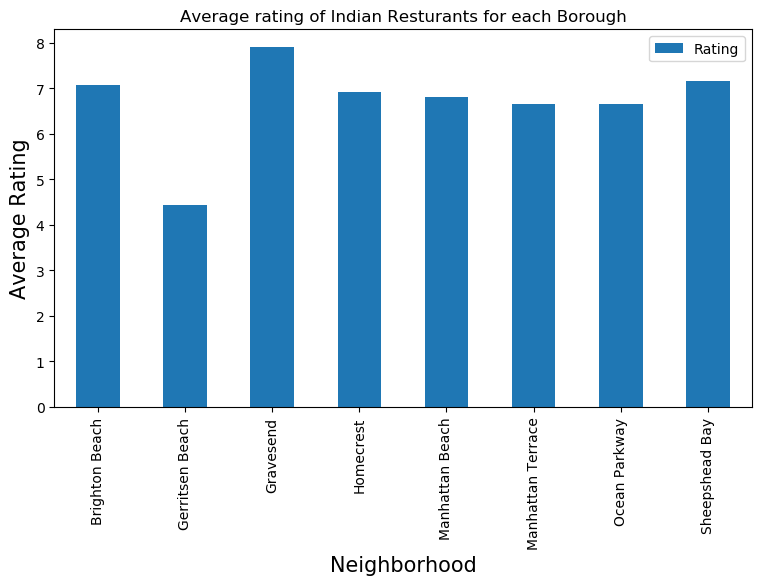

In [71]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
russian_rest_stats_ny.groupby('Neighborhood').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

,Neighborhood,Average Rating
0,Brighton Beach,7.066667
1,Gerritsen Beach,4.433333
2,Gravesend,7.900000
3,Homecrest,6.925000
4,Manhattan Beach,6.800000
5,Manhattan Terrace,6.650000
6,Ocean Parkway,6.650000
7,Sheepshead Bay,7.160000


In [73]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=6.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Brighton Beach,7.066667
2,Gravesend,7.900000
3,Homecrest,6.925000
4,Manhattan Beach,6.800000
5,Manhattan Terrace,6.650000
6,Ocean Parkway,6.650000
7,Sheepshead Bay,7.160000


In [74]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [75]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [76]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Brighton Beach,40.576825,-73.965094,7.066667
1,Brooklyn,Gravesend,40.595260,-73.973471,7.900000
2,Brooklyn,Homecrest,40.598525,-73.959185,6.925000
3,Brooklyn,Manhattan Beach,40.577914,-73.943537,6.800000
4,Brooklyn,Manhattan Terrace,40.614433,-73.957438,6.650000
5,Brooklyn,Ocean Parkway,40.613060,-73.968367,6.650000
6,Brooklyn,Sheepshead Bay,40.586890,-73.943186,7.160000


In [84]:
# create map and display it
ny_map = folium.Map(location=geo_location('Brooklyn'), zoom_start=12)

In [85]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [86]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [87]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

# Conclusion

* Brooklyn is the best place to stay if you prefer Russian Cuisine.
* Other boroughts don't have any Russian cuisine restaurants. It may 
* Gravesend (Brooklyn) is the neighboorhod with the best russian cuisine in New York.